# **Machine Learing on fNIRS data**


# 1. **Load processed data from google drive** 
*  Data was preprocessed on Matlab using homer2 scripts
*  filter -> de-trend ->  wavelet remove motion -> convert 



In [ ]:
# Load the Drive helper and mount
from google.colab import drive
import numpy as np
from scipy import stats
from scipy import signal
import scipy.io
import os
import random
import pywt
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from mpl_toolkits import mplot3d
import tensorflow as tf
import shutil
from tensorflow.keras.optimizers import RMSprop
import pywt


# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# define useful functions

# function for calcualte accuracy
def predict_accuracy (answer, output):
    length = len(answer) 
    count = 0.0;
    for ii in range(0,length):
        if answer[ii] == output[ii]:
            count = count + 1 
    return (count/length) * 100

# random sample n from 12 blocks to calculate blkavg for each subject to increade 
# training data size
# def random_sample_training (training_data, training_SID, training_ROI, training_label):


# do block average on testing data sets
# each subject will have 2 blockaverage trace only
# def blvg_testing(testing_data, testing_SID, testing_ROI, testing_label):



# wavelet transform and plot
def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (years)', 
                 xlabel = 'Time'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    #ax.set_title(title, fontsize=20)
    #ax.set_ylabel(ylabel, fontsize=18)
    #ax.set_xlabel(xlabel, fontsize=18)
    
    #yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    #ax.set_yticks(np.log2(yticks))
    #ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    
    #cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    #fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    #plt.show()
    return fig

def plot_signal_plus_average(time, signal, average_over = 5):
    fig, ax = plt.subplots(figsize=(15, 3))
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Signal Amplitude', fontsize=18)
    ax.set_title('Signal + Time Average', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    ax.legend()
    plt.show()
    
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

def plot_fft_plus_power(time, signal):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    fig, ax = plt.subplots(figsize=(15, 3))
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2     # FFT power spectrum
    ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
    ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    ax.set_xlabel('Frequency [Hz / year]', fontsize=18)
    ax.set_ylabel('Amplitude', fontsize=18)
    ax.legend()
    plt.show()
    
def get_ave_values(xvalues, yvalues, n = 5):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave

In [ ]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
# save exp1 and exp3 data as testing 
!ls "/content/drive/My Drive/fNIRS_ML_colab/data"

exp1new_ML_dataset_HbO.mat  exp1old_ML_dataset_HbR.mat	exp3_ML_dataset_HbT.mat
exp1new_ML_dataset_HbR.mat  exp1old_ML_dataset_HbT.mat	ML_dataset_HbR.mat
exp1new_ML_dataset_HbT.mat  exp3_ML_dataset_HbO.mat	ML_dataset_HbT.mat
exp1old_ML_dataset_HbO.mat  exp3_ML_dataset_HbR.mat	ML_dataset.mat


block average trace is and all labels are stored in the .mat file
*   data for all 14+14+14 subjects (exp1 new, exp1 old and exp 3) recordings
*   SID for subject label
*   ROI for region of interest label(1: left cIFS; 2: right cIFS; 3: left STG; 4: right STG)
*   label for task type label (1: active; 0: passive)

data from exp1 new (active vs. passive) as training
data from exp1 old and exp3 as testing





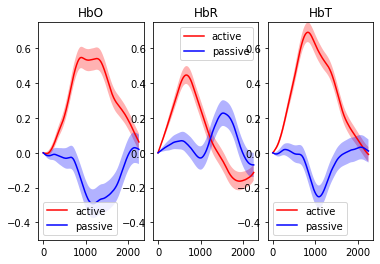

In [ ]:
# navigate to the data folder and load the preprocessed files
# ML_dataset = scipy.io.loadmat('/content/drive/My Drive/fNIRS_ML_colab/data/ML_dataset.mat')
# ML_dataset = scipy.io.loadmat('/content/drive/My Drive/fNIRS_ML_colab/data/ML_dataset_HbR.mat')
# ML_dataset = scipy.io.loadmat('/content/drive/My Drive/fNIRS_ML_colab/data/ML_dataset_HbT.mat')

for i in range(3):
  if i == 0:
    ML_dataset = scipy.io.loadmat('/content/drive/My Drive/fNIRS_ML_colab/data/exp1new_ML_dataset_HbO.mat')
    ax = plt.subplot2grid((1, 6), (0, 0), colspan=2)
    title = 'HbO'
  if i == 1:
    ML_dataset = scipy.io.loadmat('/content/drive/My Drive/fNIRS_ML_colab/data/exp1new_ML_dataset_HbR.mat')
    ax = plt.subplot2grid((1, 6), (0, 2), colspan=2)  
    title = 'HbR'
  if i == 2:
    ML_dataset = scipy.io.loadmat('/content/drive/My Drive/fNIRS_ML_colab/data/exp1new_ML_dataset_HbT.mat')
    ax = plt.subplot2grid((1, 6), (0, 4), colspan=2)  
    title = 'HbT'
    
  # load data
  data = np.asarray(ML_dataset['data'])
  SID = np.asarray(ML_dataset['SID'])
  ROI = np.asarray(ML_dataset['ROI'])
  label = np.asarray(ML_dataset['label'])

  # Plot blkavg and check to be sure we got the data right
  active_index = np.where(label == 1)[0]
  passive_index = np.where(label == 0)[0]
  data_active = data[active_index, :]
  data_passive = data[passive_index, :]

  y = np.mean(data_active,axis = 0)
  SE = np.std(data_active, axis = 0);
  SEM = SE/np.sqrt(len(data_active));
  ax.plot(range(len(y)), y, 'r', label = 'active')
  ax.fill_between(range(len(y)), y - SEM, y + SEM, alpha=0.3, facecolor='r')
    
  y = np.mean(data_passive,axis = 0)
  SE = np.std(data_passive, axis = 0);
  SEM = SE/np.sqrt(len(data_passive));
  ax.plot(range(len(y)), y, 'b', label = 'passive')
  ax.fill_between(range(len(y)), y - SEM, y + SEM, alpha=0.3, facecolor='b')
  
  ax.set_ylim([-0.5,0.75])
  ax.legend()
  ax.set_title(title)

In [ ]:
# use HbO data for now
ML_dataset = scipy.io.loadmat('/content/drive/My Drive/fNIRS_ML_colab/data/exp1new_ML_dataset_HbO.mat')
# load data
data = np.asarray(ML_dataset['data'])
SID = np.asarray(ML_dataset['SID'])
ROI = np.asarray(ML_dataset['ROI'])
label = np.asarray(ML_dataset['label'])


ML_dataset_testing = scipy.io.loadmat('/content/drive/My Drive/fNIRS_ML_colab/data/exp1old_ML_dataset_HbO.mat')
#ML_dataset_testing = scipy.io.loadmat('/content/drive/My Drive/fNIRS_ML_colab/data/exp3_ML_dataset_HbO.mat')
# load data
data_testing = np.asarray(ML_dataset_testing['data'])
SID_testing = np.asarray(ML_dataset_testing['SID'])
ROI_testing = np.asarray(ML_dataset_testing['ROI'])
label_testing = np.asarray(ML_dataset_testing['label'])

#ML_dataset_testing = scipy.io.loadmat('/content/drive/My Drive/fNIRS_ML_colab/data/exp1old_ML_dataset_HbO.mat')
ML_dataset_testing_exp3 = scipy.io.loadmat('/content/drive/My Drive/fNIRS_ML_colab/data/exp3_ML_dataset_HbO.mat')
# load data
data_testing_exp3 = np.asarray(ML_dataset_testing_exp3['data'])
SID_testing_exp3 = np.asarray(ML_dataset_testing_exp3['SID'])
ROI_testing_exp3 = np.asarray(ML_dataset_testing_exp3['ROI'])
label_testing_exp3 = np.asarray(ML_dataset_testing_exp3['label'])

print('classification using HbO data')

classification using HbO data


# **2. Prepare training and testing data sets**

In [ ]:
# choose exp1 new 14 subject as tesing, the rest as training
# SID 
# data
training_data = data
# ROI
training_ROI = ROI
# label
training_label = label

# make testing data the block average
# 14 for active and 14 for passive for experiment 1 old
# test data are block average 
testing_data_active_index = np.where(label_testing == 1)[0]
testing_data_active= []
for ID in np.unique(SID_testing[testing_data_active_index]):
    ID_index = np.where(SID_testing[testing_data_active_index] == ID)[0]
    testing_data_active.append(np.mean(data_testing[testing_data_active_index][ID_index], axis =0))
testing_data_active = np.asarray(testing_data_active)

testing_data_passive_index = np.where(label_testing == 0)[0]
testing_data_passive= []
for ID in np.unique(SID_testing[testing_data_passive_index]):
    ID_index = np.where(SID_testing[testing_data_active_index] == ID)[0]
    testing_data_passive.append(np.mean(data_testing[testing_data_passive_index][ID_index], axis =0))
testing_data_passive = np.asarray(testing_data_passive)

testing_data = np.concatenate((testing_data_active, testing_data_passive), axis =0)
testing_label = np.concatenate((np.ones(14), np.zeros(14)), axis = 0)

# make testing data the block average
# only 14 for active in experiment 3
# test data are block average 
testing_data_active= []
for ID in np.unique(SID_testing_exp3):
    ID_index = np.where(SID_testing_exp3 == ID)[0]
    testing_data_active.append(np.mean(data_testing_exp3[ID_index], axis =0))
testing_data_active = np.asarray(testing_data_active)
   
testing_data_exp3 = testing_data_active
testing_label_exp3 = np.ones(14)
   
# X is the training data set
# y is the class label
X = training_data
y = training_label[:,0]

print('classification dataset ready')

classification dataset ready


# **3. Tried methods**
*   SVM
*   Decision tree 
*   Neural Network (too few data points)



1. Simple SVM

In [ ]:
# simplest SVM with no feature selection or extraction
# train svm
# clf_svm= svm.SVC()
clf_svm = svm.SVC(kernel='rbf', probability=True)
bag = BaggingClassifier(clf_svm, n_estimators=25, max_samples=0.8, random_state=1)
clf_svm = bag.fit(X, y)

train_score = clf_svm.score(X, y)
test_score = clf_svm.score(testing_data, testing_label)
test_score_exp3 = clf_svm.score(testing_data_exp3, testing_label_exp3)
print("Train Score is : {}".format(train_score))
print("Test Score for exp 1 is : {}".format(test_score))
print("Test Score for exp 3 is : {}".format(test_score_exp3))

Train Score is : 0.6934523809523809
Test Score for exp 1 is : 0.6428571428571429
Test Score for exp 3 is : 1.0


2. DT and RF

In [ ]:
# decision tree and random forest
# each time take 80% of the training data to build a tree, build 10 trees
# voting at the end
#clf_DT = tree.DecisionTreeClassifier()
#bag = BaggingClassifier(clf_DT, n_estimators=25, max_samples=0.8, random_state=1)
#clf_DT = bag.fit(X, y)
from sklearn.ensemble import RandomForestClassifier
clf_RF = RandomForestClassifier(n_estimators=10, max_depth=200, min_samples_split=2, random_state=0)
clf_RF.fit(X, y)

# use forest to perdict 
train_score = clf_RF.score(X, y)
test_score = clf_RF.score(testing_data, testing_label)
print("Train Score is : {}".format(train_score))
print("Test Score for exp 1 is : {}".format(test_score))

# generate report and confusion matrix as well
true_label = testing_label
predicted_label = clf_RF.predict(testing_data)
cm = confusion_matrix(true_label, predicted_label, labels=clf_RF.classes_)
print(classification_report(true_label, predicted_label))
print("Confusion matrix")
print(cm)

NameError: ignored

3. ada boost decision tree

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=150),
                         algorithm="SAMME",
                         n_estimators=200)

bdt.fit(X, y)

# use forest to perdict 
# use forest to perdict 
train_score = bdt.score(X, y)
test_score = bdt.score(testing_data, testing_label)
test_score_exp3 = bdt.score(testing_data_exp3, testing_label_exp3)
print("Train Score is : {}".format(train_score))
print("Test Score for exp 1 is : {}".format(test_score))

# generate report and confusion matrix as well
true_label = testing_label
predicted_label = bdt.predict(testing_data)
cm = confusion_matrix(true_label, predicted_label, labels=clf_RF.classes_)
print(classification_report(true_label, predicted_label))


Train Score is : 1.0
Test Score for exp 1 is : 0.8214285714285714
              precision    recall  f1-score   support

         0.0       0.91      0.71      0.80        14
         1.0       0.76      0.93      0.84        14

    accuracy                           0.82        28
   macro avg       0.84      0.82      0.82        28
weighted avg       0.84      0.82      0.82        28

Confusion matrix
[[10  4]
 [ 1 13]]


4. ensemble


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier

clf1 = DecisionTreeClassifier(max_depth=100)
clf2 = KNeighborsClassifier(n_neighbors=2)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[2, 1, 2])
eclf.fit(X, y)

# use forest to perdict 
train_score = eclf.score(X, y)
test_score = eclf.score(testing_data, testing_label)
test_score_exp3 = eclf.score(testing_data_exp3, testing_label_exp3)
print("Train Score is : {}".format(train_score))
print("Test Score for exp 1 is : {}".format(test_score))
%print("Test Score for exp 3 is : {}".format(test_score_exp3))

Train Score is : 1.0
Test Score for exp 1 is : 0.6785714285714286
Test Score for exp 3 is : 0.8571428571428571


5. NN


> Generate training set from wavelet transformation from training data and save (only need to run once)

In [ ]:
# RUN ONCE ONLY
# NN implemented in tensorflow
# 1. perform stft on each trainset row, use the stft plot as the input for training
# 2. apply NN using tensor flow
# sampling frequence Fs = 50 Hz
Fs = 50
N = 10 * Fs
nperseg = 5
amp = 2 * np.sqrt(2)
N = X.shape[1]
t0=0
dt=0.02
time = np.arange(0, N) * dt + t0
scales = np.arange(1, 128)

# training data
fig_path='/content/drive/My Drive/fNIRS_ML_colab/images_training/'
fig_path_active = '/content/drive/My Drive/fNIRS_ML_colab/images_training/active/'
fig_path_passive = '/content/drive/My Drive/fNIRS_ML_colab/images_training/passive/'
if os.path.exists(fig_path):
  shutil.rmtree(fig_path)
if not os.path.exists(fig_path_active) or not os.path.exists(fig_path_passive) or not os.path.exists(fig_path):
  os.makedirs(fig_path)
  os.makedirs(fig_path_active)
  os.makedirs(fig_path_passive)
for ii in range(len(X)):
  # generate graph as save as input for training
  signal = X[ii,:]
  fig = plot_wavelet(time, signal, scales)
  
  if training_label[ii] == 1:
    fig_name = 'active_'+str(ii)+'.png'
    fig_filename = os.path.join(fig_path_active, fig_name)
    fig.savefig(fig_filename)
  else:
    fig_name = 'passive_'+str(ii)+'.png'
    fig_filename = os.path.join(fig_path_passive, fig_name)
    fig.savefig(fig_filename)
  plt.close()
    
# testing data
fig_path='/content/drive/My Drive/fNIRS_ML_colab/images_testing_exp1/'
fig_path_active = '/content/drive/My Drive/fNIRS_ML_colab/images_testing_exp1/active/'
fig_path_passive = '/content/drive/My Drive/fNIRS_ML_colab/images_testing_exp1/passive/'
if os.path.exists(fig_path):
  shutil.rmtree(fig_path)
if not os.path.exists(fig_path_active) or not os.path.exists(fig_path_passive) or not os.path.exists(fig_path):
  os.makedirs(fig_path)
  os.makedirs(fig_path_active)
  os.makedirs(fig_path_passive)
for ii in range(len(testing_data)):
  signal = testing_data[ii,:]
  fig = plot_wavelet(time, signal, scales)

  if testing_label[ii] == 1:
    fig_name = 'active_'+str(ii)+'.png'
    fig_filename = os.path.join(fig_path_active, fig_name)
    fig.savefig(fig_filename)
  else:
    fig_name = 'passive_'+str(ii)+'.png'
    fig_filename = os.path.join(fig_path_passive, fig_name)
    fig.savefig(fig_filename)
  plt.close()

print("All images saved")

/usr/local/lib/python3.6/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


All images saved


In [ ]:
# load from images folder and prepare training set
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/fNIRS_ML_colab/images_training/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=128,
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/content/drive/My Drive/fNIRS_ML_colab/images_testing_exp1/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=32,
        class_mode='binary')

Found 2015 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


In [ ]:
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>0.9):
      print("\nVal_acc reached 90% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

# build model then start training
from keras.layers import Dropout
model = tf.keras.models.Sequential([
    # first convolution
    tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    #tf.keras.layers.Conv2D(64, (5,5), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    # 1000 neuron hidden layer
    tf.keras.layers.Dense(128, activation='relu'),
    # Add a dropout layer for previous hidden layer
    # tf.keras.layers.Dropout(0.2),
    # 500 neuron hidden layer
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    # Only 1 output neuron.
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

# compile
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

# start training and testing
history = model.fit_generator(
      train_generator,
      steps_per_epoch=1000,  
      epochs=50,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=10,
      callbacks=[callbacks])

Using TensorFlow backend.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 146, 146, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 170528)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               21827712  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 21,838,465
Trainable params: 21,838,465
Non-trainable params: 0
____________________________________________

KeyboardInterrupt: ignored